# Predicting jet engine failure events 

This notebook uses a dataset of simulated jet engine sensor data to attempt prediction of failure events before they occur. Specifically, the model should predict that a failure event is imminent within n cycles before the actual failure occurs. In a real-world setting, this could be used to guide e.g., predictive maintenance or optimization of engine usage 

The dataset of simulated aircraft engine run-to-failure events is taken from a Microsoft Azure demonstration case (1)

<img src='images/turbine_01.JPG' width='600' height='600'/>

### Approach <a class="tocSkip">

The model is developed to **optimize typical evaluation metrics** (Accuracy, Recall, and Precision) with a self-imposed **constraint** that no engine should fail without at least 5 cycles of advance warning. In other words, the model is trained towards raising a warning n cycles prior to outage (where n>5) while reducing the probability of not raising a warning at least 5 cycles prior to outage effectively to zero.  

This notebook encompasses broadly four sections:

1. Data exploration 
2. Data formatting and augmentation
3. Training of ML model
4. Discussion of results

The core model in this notebook is a multi-layer LSTM (Long Short Term Memory) network processing chunks of 50 time series steps of input data. The idea is to identify patterns that correlate with failure events in the training data which can be generalized to new data. Here is a brief description of how LSTM cells differ from basic RNN architecture: http://colah.github.io/posts/2015-08-Understanding-LSTMs/  

Besides raw sensor data, the model will also receive the following inputs: 
- number of cycles since engine start
- various engineered features (rolling window mean, selective rolling window standard deviation, and selective rolling window mean difference between sensor output values). 

Some of the data preprocessing functions have been inspired by (and modified from) code found in the Microsoft Azure github respository (2)

### Result: <a class="tocSkip">
When asked to predict engine failure events 15 cycles prior to occurring, the final model achieves the following evaluation metrics while not violating the constraint of always giving at least 5 cycles of advance warning: 

- Accuracy: >99.5% 
- Precision: >80%
- Recall: >90% 

I am presenting ranges here because the dataset is limited in size and actual model performance oscillates based on the last training step. In this setup, the model robustly fulfills the constraint of predicting engine failure at least 5 cycles in advance. In fact, I did not observed an instance where there were not at least 11 cycles of advance warning by the model.  

The LSTM model is compared against two alternative solutions: 
1. **"All zeros solution"** -- Since we have a large imbalance in the dataset between normal engine states and critical engine states (with the latter being much rarer), I calculated the Accuracy of a "model" that was never to predict a critical engine state. Such a "model" would achieve c. 98%, though would otherwise be useless. This is still an interesting baseline to compare against. 
2. **"naive" solution** -- As a true **baseline model**, I used the average number of non-critical engine cycles in the training set and applied this "naively" to the evaluation set (i.e., always predicting the previously observed average for when the engine reached a critical state). This is the simplest model imaginable and achieved the following baseline metrics:  


- Accuracy:  89.3%
- Precision:  6.1%
- Recall:  38.5%

### About the dataset: <a class="tocSkip">

The dataset of simulated aircraft engine run-to-failure events is taken from a Microsoft Azure demonstration case (1). The dataset encompasses simulated time series data of various sensors from 100 engines, where each engine is assumed to start with different degrees of initial wear and manufacturing variation, which is unknown to the user. Quoting from the website: *"In this simulated data, the engine is assumed to be operating normally at the start of each time series. It starts to degrade at some point during the series of the operating cycles. The degradation progresses and grows in magnitude. When a predefined threshold is reached, then the engine is considered unsafe for further operation. In other words, the last cycle in each time series can be considered as the failure point of the corresponding engine."*


(1) https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
(2) https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning% \
20Basics%20for%20Predictive%20Maintenance.ipynb

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Data-preprocessing" data-toc-modified-id="1-Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1 Data preprocessing</a></span><ul class="toc-item"><li><span><a href="#1.1-Importing-the-raw-data" data-toc-modified-id="1.1-Importing-the-raw-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1.1 Importing the raw data</a></span></li><li><span><a href="#1.2-Taking-a-look-at-data-summary-statistics" data-toc-modified-id="1.2-Taking-a-look-at-data-summary-statistics-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>1.2 Taking a look at data summary statistics</a></span></li><li><span><a href="#1.3-Taking-a-closer-look-at-the-number-of-cycles-prior-to-failure-events" data-toc-modified-id="1.3-Taking-a-closer-look-at-the-number-of-cycles-prior-to-failure-events-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>1.3 Taking a closer look at the number of cycles prior to failure events</a></span></li><li><span><a href="#1.4-Visualizing-correlations-across-input-features" data-toc-modified-id="1.4-Visualizing-correlations-across-input-features-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>1.4 Visualizing correlations across input features</a></span></li><li><span><a href="#1.5-Visualizing-sensor-data" data-toc-modified-id="1.5-Visualizing-sensor-data-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>1.5 Visualizing sensor data</a></span></li></ul></li><li><span><a href="#2-Data-formatting-and-augmentation" data-toc-modified-id="2-Data-formatting-and-augmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2 Data formatting and augmentation</a></span><ul class="toc-item"><li><span><a href="#2.1-Generating-the-truth-labels" data-toc-modified-id="2.1-Generating-the-truth-labels-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1 Generating the truth labels</a></span></li><li><span><a href="#2.2-Splitting-dataset-into-train-and-evaluation-set" data-toc-modified-id="2.2-Splitting-dataset-into-train-and-evaluation-set-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2.2 Splitting dataset into train and evaluation set</a></span></li><li><span><a href="#2.3-Applying-MinMax-normalization" data-toc-modified-id="2.3-Applying-MinMax-normalization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>2.3 Applying MinMax normalization</a></span></li><li><span><a href="#2.4-Generating-&quot;naive&quot;-estimate-for-the-label" data-toc-modified-id="2.4-Generating-&quot;naive&quot;-estimate-for-the-label-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>2.4 Generating "naive" estimate for the label</a></span></li><li><span><a href="#2.5-Prepare-input-matrix" data-toc-modified-id="2.5-Prepare-input-matrix-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>2.5 Prepare input matrix</a></span></li></ul></li><li><span><a href="#3-Setting-up-and-training-the-model" data-toc-modified-id="3-Setting-up-and-training-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3 Setting up and training the model</a></span><ul class="toc-item"><li><span><a href="#3.1-Running-the-model" data-toc-modified-id="3.1-Running-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>3.1 Running the model</a></span></li></ul></li><li><span><a href="#4-Discussing-model-results" data-toc-modified-id="4-Discussing-model-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4 Discussing model results</a></span><ul class="toc-item"><li><span><a href="#4.1-Evaluation-metrics" data-toc-modified-id="4.1-Evaluation-metrics-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>4.1 Evaluation metrics</a></span></li><li><span><a href="#4.2-Models" data-toc-modified-id="4.2-Models-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>4.2 Models</a></span></li><li><span><a href="#4.3-All-zeros-&quot;model&quot;" data-toc-modified-id="4.3-All-zeros-&quot;model&quot;-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>4.3 All zeros "model"</a></span></li><li><span><a href="#4.4-&quot;Naive&quot;-baseline-model" data-toc-modified-id="4.4-&quot;Naive&quot;-baseline-model-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>4.4 "Naive" baseline model</a></span></li><li><span><a href="#4.5-LSTM-model-with-raw-features-only" data-toc-modified-id="4.5-LSTM-model-with-raw-features-only-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>4.5 LSTM model with raw features only</a></span></li><li><span><a href="#4.6-LSTM-with-augmented-features-added" data-toc-modified-id="4.6-LSTM-with-augmented-features-added-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>4.6 LSTM with augmented features added</a></span></li><li><span><a href="#4.7-Taking-a-closer-look-at-sample-predictions" data-toc-modified-id="4.7-Taking-a-closer-look-at-sample-predictions-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>4.7 Taking a closer look at sample predictions</a></span></li><li><span><a href="#4.8-Testing-whether-all-engines-in-the-evaluation-set-receive-at-least-5-cycles-of-warning" data-toc-modified-id="4.8-Testing-whether-all-engines-in-the-evaluation-set-receive-at-least-5-cycles-of-warning-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>4.8 Testing whether all engines in the evaluation set receive at least 5 cycles of warning</a></span></li></ul></li></ul></div>

## 1 Data preprocessing  

In [17]:
# loading packages 
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [304]:
dataframe = pd.read_csv('data\Turbine_data\PredictiveManteinanceEngine_01.csv', sep=',')
dataframe = dataframe.drop(columns = ['label1', 'label2'])
# make sure data is properly sorted 
dataframe = dataframe.sort_values(['id','cycle'])

### 1.1 Importing the raw data

In [305]:
dataframe.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.01108


The dataset consists of the following data columns: 
- **id** -- engine id, where each id corresponds to one single engine 
- **cycle** -- number of cycles (time steps) since the start of observations 
- **setting1 -- setting3** -- engine settings
- **s1 - s21** -- sensor readings 
- **RUL** -- Remaining Useful Life (number of cycles until failure event). This is not used as input, but as a helper to create labels 

### 1.2 Taking a look at data summary statistics 
- There are 20,631 rows of recorded cycles in the dataset distributed over 100 engine IDs
- The columns "setting3", "s1", "s5", "s10", "s16", "s18", and "s19" are empty (and will be subsequently deleted)

In [306]:
pd.set_option('display.max_columns', 30)
dataframe.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,0.499490,0.501959,0.0,0.0,0.443052,0.424746,0.450435,0.0,0.980321,0.566459,0.297957,0.195248,0.0,0.411410,0.580697,0.317871,0.226095,0.451118,0.0,0.434221,0.0,0.0,0.524241,0.546127,107.807862,0.298637
std,29.227633,68.880990,0.125708,0.244218,0.0,0.0,0.150618,0.133664,0.151935,0.0,0.138898,0.142527,0.107554,0.099089,0.0,0.158981,0.157261,0.105763,0.098442,0.144306,0.0,0.129064,0.0,0.0,0.140114,0.149476,68.880990,0.190806
min,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,0.413793,0.333333,0.0,0.0,0.335843,0.331807,0.339467,0.0,1.000000,0.476651,0.227273,0.140761,0.0,0.297619,0.484009,0.235294,0.171870,0.346287,0.0,0.333333,0.0,0.0,0.434109,0.452361,51.000000,0.141274
50%,52.000000,104.000000,0.500000,0.500000,0.0,0.0,0.430723,0.415522,0.435348,0.0,1.000000,0.578100,0.287879,0.174684,0.0,0.392857,0.594883,0.308824,0.209516,0.438630,0.0,0.416667,0.0,0.0,0.534884,0.557443,103.000000,0.285319
75%,77.000000,156.000000,0.586207,0.750000,0.0,0.0,0.539157,0.508829,0.545324,0.0,1.000000,0.669887,0.363636,0.213991,0.0,0.505952,0.695096,0.382353,0.249613,0.541362,0.0,0.500000,0.0,0.0,0.627907,0.652582,155.000000,0.429363
max,100.000000,362.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,361.000000,1.000000


In [307]:
# drop empty columns 
dataframe = dataframe.drop(columns = ['setting3', 's1', 's5', 's10', 's16', 's18', 's19'])

### 1.3 Taking a closer look at the number of cycles prior to failure events
We can see below that the number of cycles prior failure events ranges between 128 and 362 cycles in the dataset (i.e., a fairly wide spread). The majority of engines seem to encounter failure events c. 200 cycles after start of observation

In [308]:
# find cycle lengths in dataset
max_cycles = pd.DataFrame(dataframe.groupby('id')['cycle'].max())
longest_cycle = max_cycles['cycle'].max()
shortest_cycle = max_cycles['cycle'].min()
print('Cycle lenght ranges between', str(shortest_cycle), 'and', str(longest_cycle), 'cycles')

Cycle lenght ranges between 128 and 362 cycles


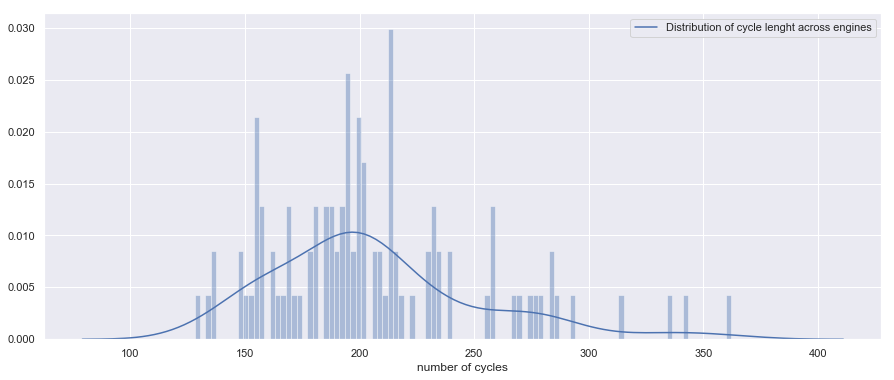

In [309]:
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(np.array(max_cycles['cycle']), bins=100, axlabel='number of cycles', 
             kde_kws={"label": "Distribution of cycle lenght across engines"})

### 1.4 Visualizing correlations across input features

The pairwise correlation matrix below surprisingly reveals that there seems to be no correlation between the values of settings 1 and 2 and any other feature. Also, sensor 6 seems to be less correlated to other sensors than the rest of the sensor cohort towards each other. 

In [310]:
def show_pairwise_correlations(): 
    # Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    corr = dataframe.corr()
    # Generate a mask to hide the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

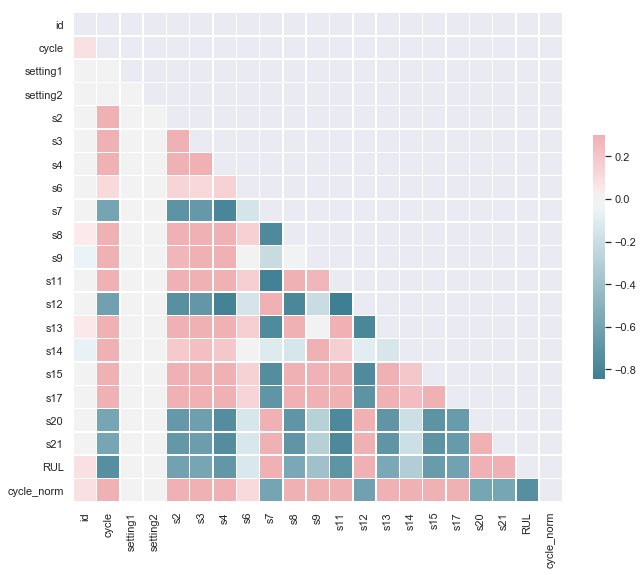

In [311]:
show_pairwise_correlations()

### 1.5 Visualizing sensor data 

In the following plot of sensor data output for a single engine, we see that a group of sensors seem to track downward while another group tracks generally upward. With some variation, this holds true across all engines in the dataset 

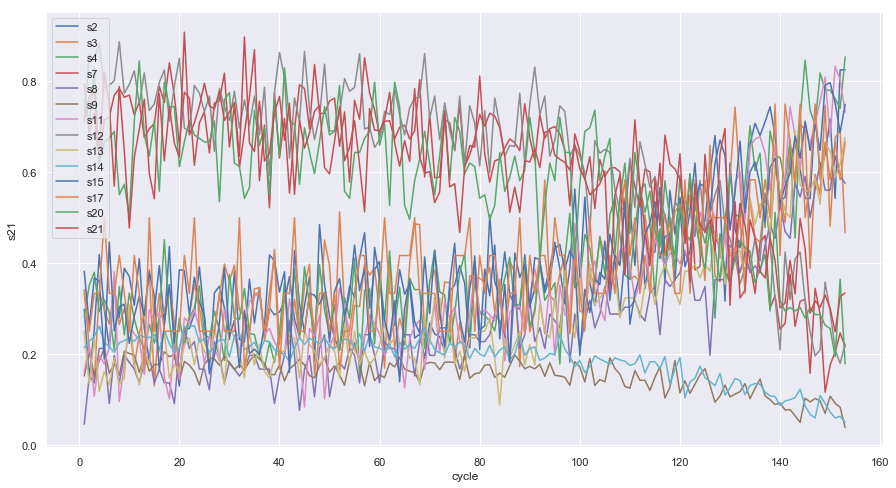

In [314]:
id = 65 
sns.set(rc={'figure.figsize':(15,8)})
sensors = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
           's20', 's21']
for sensor in sensors: 
    sns.lineplot(x=dataframe.cycle[dataframe['id']==id], y=dataframe[sensor][dataframe['id']==id], 
                 label=sensor)

The counter-tracking trend observed above is particularly pronounced for sensors s2, s3, and s20, s21:

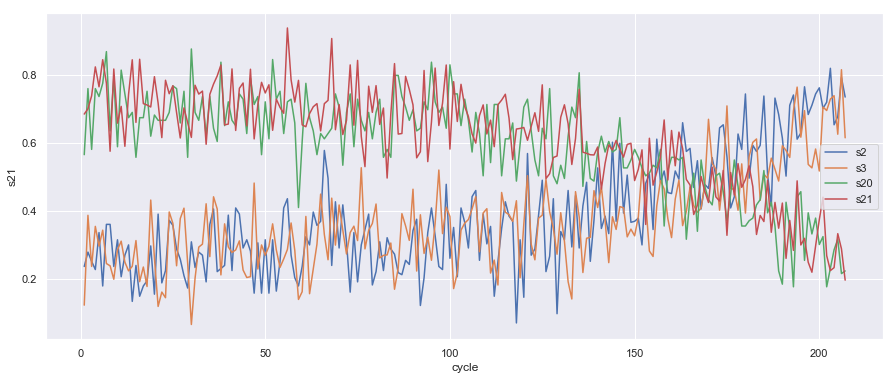

In [342]:
sensors = ['s2', 's3', 's20', 's21']
sns.set(rc={'figure.figsize':(15,6)})
for sensor in sensors: 
    sns.lineplot(x=dataframe.cycle[dataframe['id']==15], y=dataframe[sensor][dataframe['id']==15], 
                 label=sensor)

Other sensors, such as s9 and s14 vary in their overall trajectory from engine to engine 

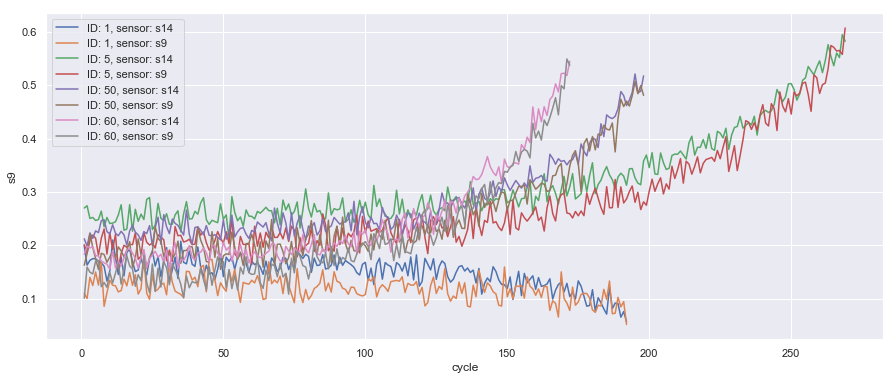

In [343]:
ids = [1, 5, 50, 60]
sensors = ['s14', 's9']
sns.set(rc={'figure.figsize':(15,6)})
for id in ids: 
    for sensor in sensors: 
        sns.lineplot(x=dataframe.cycle[dataframe['id']==id], y=dataframe[sensor][dataframe['id']==id], 
                     label='ID: '+str(id)+', sensor: '+sensor)

Sensor s6 appears to be binary in output with no immediately evident pattern (except for more 0 events earlier in the cycles for some engines)

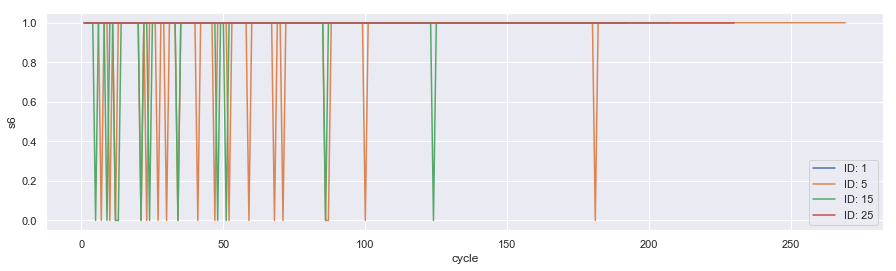

In [325]:
ids = [1, 5, 15, 25]
sns.set(rc={'figure.figsize':(15,4)})
for id in ids: 
    sns.lineplot(x=dataframe.cycle[dataframe['id']==id], y=dataframe['s6'][dataframe['id']==id], 
                 label='ID: '+str(id))

## 2 Data formatting and augmentation

We will transform the sensor input data in three different ways: 

1. **Rolling window mean:** since the sensor data output appears to be quite noisy, averaging values over the preceding x steps could help the model distinguish the signal from the pure noise 
2. **Rolling window standard deviation:** as will become apparent shortly, it seems that data noisiness (i.e., standard deviation) of sensor output oscillates and reaches specific ranges just before failure events. We will thus add rolling window standard deviations for specific sensors to the input 
3. **Rolling window mean difference:** as seen earlier, certain sensors tend to have specific trajectories in their output values and seem to cross over in value relative to each other just before a failure event. We will thus compute the difference of the rolling mean for specific sensors and add to the input 

#### Rolling window mean

In [326]:
# 1 Compute rolling window means
def rolling_mean(replace=False, window_size=5): 
    ids = dataframe['id'].unique()
    sensors = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
               's20', 's21']
    for sensor in sensors: 
        if replace is False: 
                dataframe[sensor+'_'+str(window_size)] = 0
        for id in ids:           
            df = dataframe[sensor][dataframe['id']==id].rolling(window=window_size, 
                                                                min_periods=0).mean()
            if replace is False: 
                dataframe[sensor+'_'+str(window_size)][dataframe['id']==id] = df
            else:    
                dataframe[sensor][dataframe['id']==id] = df 

In [327]:
rolling_mean(replace=False, window_size=10)

The plot below shows how the rolling window mean reduces the noise of the original input

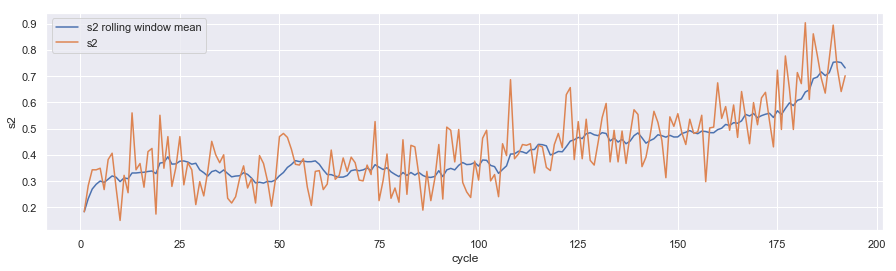

In [329]:
sns.lineplot(x=dataframe.cycle[dataframe['id']==1], y=dataframe.s2_10[dataframe['id']==1], 
             label='s2 rolling window mean')
sns.lineplot(x=dataframe.cycle[dataframe['id']==1], y=dataframe.s2[dataframe['id']==1], label='s2')

#### Rolling window standard deviation 

In [330]:
# 2 Compute rolling window standard deviation 
def rolling_std(window_size=5): 
    ids = dataframe['id'].unique()
    sensors = ['s7', 's11', 's15', 's20', 's21']
    for sensor in sensors: 
        dataframe[sensor+'_stdv'] = 0
        for id in ids: 
            df = dataframe[sensor][dataframe['id']==id].rolling(window=window_size).std()
            df = df.rolling(window=window_size).mean()
            dataframe[sensor+'_stdv'][dataframe['id']==id] = df

In [331]:
rolling_std(window_size=30)

The plot below shows how the standard deviation of sensor s7 for a 30 step window changes over time for a few example engines

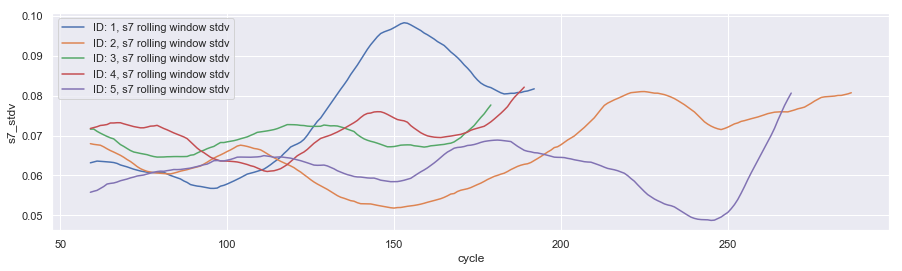

In [333]:
ids = [1,2,3,4,5]
for id in ids: 
    sns.lineplot(x=dataframe.cycle[dataframe['id']==id], y=dataframe.s7_stdv[dataframe['id']==id],
                label = 'ID: '+str(id)+', s7 rolling window stdv')

#### Rolling window mean difference 

In [334]:
# feature engineering: rolling mean differences
def rolling_mean_dif(window=50): 
    ids = dataframe['id'].unique()
    sensors1 = ['s2', 's20']
    sensors2 = ['s3', 's21']
    for s1, s2 in sensors1, sensors2: 
        dataframe[s1+'_'+s2] = 0
        for id in ids: 
            df1 = dataframe[s1][dataframe['id']==id].rolling(window=window, 
                                                                    min_periods=window).mean()
            df2 = dataframe[s2][dataframe['id']==id].rolling(window=window, 
                                                                    min_periods=window).mean()
            df = df1 - df2 
            dataframe[s1+'_'+s2][dataframe['id']==id] = df

In [335]:
rolling_mean_dif(window=50)

In [336]:
dataframe = dataframe.fillna(0)

The plot below shows rolling window mean difference for sensors s2 and s20, as well as sensors s3 and s21. They tend to have a distinct upward trajectory for all engines reaching a zero value a number of steps prior to a failure event

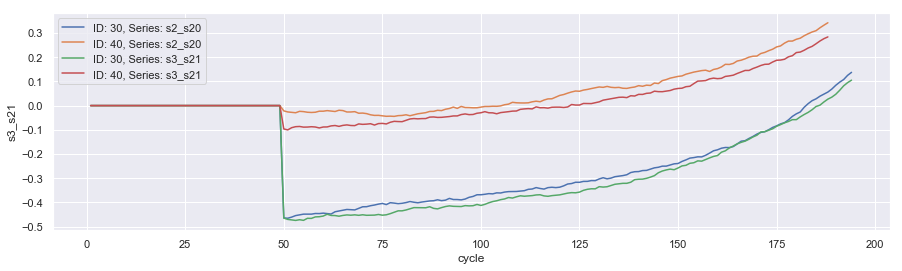

In [338]:
ids = [30, 40]
sensors = ['s2_s20', 's3_s21']
sns.set(rc={'figure.figsize':(15,4)})
for sensor in sensors: 
    for id in ids: 
        sns.lineplot(x=dataframe.cycle[dataframe['id']==id], y=dataframe[sensor][dataframe['id']==id], 
                 label='ID: '+str(id)+', Series: '+sensor)

### 2.1 Generating the truth labels

In order to train the model, we label each cycle according to its distance from a failure event. If the failure event is more than e.g., 15 cycles away, the label shall be 0. Otherwise it is 1. This sets up the model classification task

In [344]:
# The column label1 indicates when there is 10 or less cycles until engine fails 
cycles_to_failure = 15 
dataframe['label1'] = np.where(dataframe['RUL'] <= cycles_to_failure, 1, 0 )

### 2.2 Splitting dataset into train and evaluation set 

We need to split the dataset into a training and evaluation set (in this case, using a ratio of 85:15). The splitting will be done by engines so that all observations from one engine are either in one set or the other. 

The below function also extracts the average number of cycles when training set engines become critical (i.e., their label changes to 1). We will apply this later to the evaluation set to generate a "naive" estimate for when they reach critically. This will then be used to calculate baseline accuracy against which to measure model performance. 

In [168]:
# splitting data into train and evaluation set 
def split_dataset(dataframe, split_ratio=0.85):
    """
    split dataset into train and evaluation sets by randomly assigning engines IDs to one or the other
    based on split ratio. Also calculates the average number of cycles until engines in train set 
    become critical to subsequently use as model baseline
    """
    
    # create random list of indices 
    num_engines = len(dataframe['id'].unique())
    indices = np.random.permutation(num_engines)
    split = int(num_engines * split_ratio)
     
    # split list of indices into train and dev 
    training_ind, eval_ind = indices[:split], indices[split:]
      
    # apply list of indices to images, patient data and labels 
    train_df = dataframe[dataframe['id'].isin(training_ind)]
    eval_df = dataframe[dataframe['id'].isin(eval_ind)]
    
    # calculate avg. number of cycles until train set engines become critical 
    critical_cycles_df = train_df[train_df['label1']==1]
    critical_cycles = pd.DataFrame(critical_cycles_df.groupby('id')['cycle'].min())
    avg_crit_cycles = int(np.average(critical_cycles))
    
    return train_df, eval_df, avg_crit_cycles  

In [170]:
train_df, eval_df, avg_crit_cycles = split_dataset(dataframe, split_ratio=0.88)
print(train_df.shape)
print(eval_df.shape)
print('In the training set, the engines reach a critical state after' +avg_crit_cycles+ ' cycles on average')

(18060, 44)
(2371, 44)
190


### 2.3 Applying MinMax normalization 
The following function ensures that all training input data is normalized to the same range. The training set normalization is also applied to the evaluation set

In [171]:
# MinMax normalization
# choose columns to normalize (all except ...)
def minmax_norm(train_df, test_df):
    # normalize training df
    cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1'])
    min_max_scaler = preprocessing.MinMaxScaler()

    norm_dataframe = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)
    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_dataframe)
    train_df = join_df.reindex(columns = train_df.columns)
    
    # apply normalization to test df 
    norm_dataframe = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
    join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_dataframe)
    test_df = join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)    
    
    return train_df, test_df

In [172]:
train_df_norm, eval_df_norm = minmax_norm(train_df, eval_df)

### 2.4 Generating "naive" estimate for the label

The following function applies the average number of cycles when the training set engine reaches criticality to both the training and evaluation set. This will be used to calculate model evaluation metrics which can serve as a baseline for model performance. 

In [173]:
# generate naive labels 
def gen_naive_labels(eval_df, avg_crit_cycles): 
    eval_df['naive_label'] = np.where(eval_df['cycle']<avg_crit_cycles, 0, 1) 
    return eval_df 

In [174]:
eval_df_n = gen_naive_labels(eval_df, avg_crit_cycles)
train_df_n = gen_naive_labels(train_df, avg_crit_cycles)

### 2.5 Prepare input matrix

In this step, we will extract sequences of a specified number of cycles from the dataset. For example: engine ID #1 has 192 cycles recorded, so we would extract the sequences
- cycle[0]-cycle[50] 
- cycle[1]-cycle[51] 
- ...
- cycle[142]-cycle[192]

Here is how the transformation looks like in detail. We start with our initial tabular dataset, which shows for each engine ID the number of cycles it was running for. Each cycle is captured in a row with its associated sensor readings (marked as "features" below)

<img src='images/turbine_data_original.jpg' width='500' height='500'/>

Next, we extract a **number of consecutive cycles** (i.e., consecutive time steps) from each engine, which we can call seq1, seq2, etc., 

<img src='images/turbine_data.jpg' width='500' height='500'/>

These sequences then get stored into a three-dimensional numpy array that captures the following: 
- Dimension 1: All sequences 
- Dimension 2: For each sequence, the number of cycles per sequence (50 in this example) 
- Dimension 3: For each cycle, the associated sensor readings (i.e., features) 

<img src='images/turbine_features.JPG' width='500' height='500'/>

At the same time, we can also extract sequences of labels that record at what cycle step we come critically close to engine failure (e.g., 15 cycles before failure) and mark those cycles with a 1 (instead of 0). The model will learn to predict this change in labels based on the sequences of sensor data

<img src='images/turbine_labels.JPG' width='500' height='500'/>

The below function implements this recipe

In [175]:
# function to reshape features into (samples, time_steps, features). Source (1) 
sequence_length = 50
def exract_sequences(dataset, seq_length, feature_cols, labels):
    """
    Extracts continuous sequences of cycles/timesteps from the dataset and combines them in one 
    numpy array of shape (number of cycle sequences, sequence length, datapoints per cycle)
    Arguments: 
        dataset -- pandas dataframe
        seq_lenght -- number of cycle steps to extract for each sequence (integer)
        feature_cols -- list of column names from which to take datapoints (i.e., sensor readings)
    Returns: 
        sequence_matrix -- numpy array containing all sequences of shape
        (number of cycle sequences, sequence length, datapoints per cycle) 
    """
    # Get list of engine ID's in dataset 
    IDs = dataset['id'].unique()
    
    # create empty numpy arrays to hold all sequences and labels 
    sequence_matrix = np.ndarray(shape=(0, seq_length, len(feature_cols)), dtype=np.float32)
    labels_matrix = np.ndarray(shape=(0, seq_length), dtype=np.int32)
    naive_labels_matrix = np.ndarray(shape=(0, seq_length), dtype=np.int32)
    
    # Iterate through each ID and extract sequences 
    for ID in IDs: 
        # extract all values corresponding to ID as new dataframe
        ID_df = dataset[dataset['id'] == ID]
        # extract relevant columns only 
        features_array = np.array(ID_df[feature_cols])
        labels_array =  np.array(ID_df[labels])
        naive_labels_array = np.array(ID_df['naive_label'])
        # get number of sequences for ID 
        num_elements = features_array.shape[0]+1
        # create empty container for sequences 
        features_sequences = np.ndarray(shape=(0, seq_length, len(feature_cols)), dtype=np.float32)
        label_sequences = np.ndarray(shape=(0, seq_length), dtype=np.int32)
        naive_label_sequences = np.ndarray(shape=(0, seq_length), dtype=np.int32)
        # moving sliding window of lenght seq_length through ID_array and extract each as one sequence
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            features_temp = features_array[start:stop, :]
            labels_temp = labels_array[start:stop]
            naive_labels_temp = naive_labels_array[start:stop]
            features_temp = np.reshape(features_temp, (1, features_temp.shape[0], features_temp.shape[1]))
            labels_temp = np.reshape(labels_temp, (1, labels_temp.shape[0]))
            naive_labels_temp = np.reshape(naive_labels_temp, (1, naive_labels_temp.shape[0]))
            features_sequences = np.append(features_sequences, features_temp, axis=0)
            label_sequences = np.append(label_sequences, labels_temp, axis=0)
            naive_label_sequences = np.append(naive_label_sequences, naive_labels_temp, axis=0)
        # add data_matrix to sequence_matrix 
        sequence_matrix = np.append(sequence_matrix, features_sequences, axis=0)
        labels_matrix = np.append(labels_matrix, label_sequences, axis=0)
        naive_labels_matrix = np.append(naive_labels_matrix, naive_label_sequences, axis=0)
    
    return sequence_matrix, labels_matrix, naive_labels_matrix

In [345]:
# define raw feature columns for the model (also storing labels temporarily)
feature_cols = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
                's20', 's21', 
                'label1']

labels = ['label1']

In [391]:
# define augmented feature columns for the model (also storing labels temporarily)
feature_cols = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
                's20', 's21', 
                's2_10', 's3_10', 's4_10', 's7_10', 's8_10', 's9_10', 's11_10', 's12_10', 
                's13_10', 's14_10', 's15_10', 's17_10', 's20_10', 's21_10',
                's7_stdv', 's11_stdv', 's15_stdv', 's20_stdv', 's21_stdv', 
                's2_s20', 's3_s21', 'cycle_norm', 'label1']

labels = ['label1']

In [392]:
# run function on train_df and eval_df
train_features, train_labels, train_naive_labels = exract_sequences(train_df_n, 50, feature_cols, 
                                                                    labels)
eval_features, eval_labels, eval_naive_labels = exract_sequences(eval_df_n, 50, feature_cols, labels)

# check shape
print(train_features.shape)
print(eval_features.shape)
print(train_labels.shape)
print(eval_naive_labels.shape)

(13748, 50, 38)
(1832, 50, 38)
(13748, 50)
(1832, 50)


We have extracted the following for the augmented data case: 

- **Training set:** 13,748 sequences of lenght 50 cycles with 38 sensor readings and augmentations for each cycle
- **Evaluation set:** 1,832 sequences of lenght 50 cycles with 38 sensor readings for each cycle

## 3 Setting up and training the model

The ML model is distributed across the following seven functions: 

1. **input function** -- this function feeds the model with training and evaluation data. During training, it feeds shuffled batches of data. **Importantly, it feeds data in batch major mode,** i.e., in the shape of (batch_size, cycle_length, num_features). Since the tensorflow implementation also seems to misalign features and labels during shuffling, both features and labels will be passed to the model function within the "features" tensor and only then unpacked 
2. **LSTM forward pass** -- this function defines the actual neural network and is called by the model function. It consists of 3 stacked LSTM cells with 200, 100, and 50 nodes respectively. The output of the LSTM cells at each time step gets subsequently processed by two fully-connected layers (32, and 2 nodes as well as leaky ReLU activation respectively). **Importantly, the tensorflow implementation of the LSTM cells requires cycle major input data,** i.e., of shape (cycle_length, batch_size, num_features) 
3. **loss function** -- this function computes the softmax cross entropy loss for each time step based on the output of the LSTM forward pass and the labels. **Importantly, it includes a weight term such that it allows 0 and 1 labels to receive different weights when the loss term is computed.** Since the dataset contains many more 0 labels than 1 labels, this prevents the model from collapsing to a solution where it only predicts 0 labels. It is also a crucial hyperparameter for tuning the trade-off between Recall and Precision   
4. **predict function** -- this function predicts the class (0 or 1) as well as the associated probabilities for each time step based on the input of the LSTM forward pass
5. **evaluation function** -- this function computes the Accuracy, AUC (Area Under The Curve), Precision, and Recall metrics for the evaluation set based on the input of the predict function and the labels
6. **model function** -- the model function receives the data input from the input function and connects and coordinates functions 2-5
7. **train and evaluate** -- the train and evaluate function wraps the model function and coordinates training as well as regular evaluation of the model performance against the evaluation set

**A note on hyperparameters:** I found that starting with a mid-sized batch size during training (i.e., 128) and a relatively large loss weight for instances of 1 labels (i.e., ratios of 10:1-20:1) allows for relatively fast convergence while preventing the model from collapsing towards the "zero solution". As training goes on, I have increased batch sizes in steps to 1024 while lowering the relative loss weights to a ratio of 5:1, which enable a Recall metric at c. 95% and Precision at 65-80%. Both these metrics are extremely sensitive to the weight hyperparameter given that the 0 label is c. 50 times more common  

In [145]:
# create input function.  
def make_input(features, labels, num_epochs, batch_size=128, shuffle_state=False):
    """
    features -- 
    labels -- 
    num_empochs -- set to 0 for training and 1 for evaluation and predicting 
    shuffle_state -- set to True for training 
    batch_size -- set mini batch size for training
    """
    return tf.estimator.inputs.numpy_input_fn(
        x = dict({'features': features}),
        y = labels,
        batch_size = batch_size,
        num_epochs = num_epochs,
        shuffle = shuffle_state,
        queue_capacity = 1000,
        num_threads = 1,    
    )    

In [246]:
def LSTM_forward(features_series, batch_size):
    # LSTM FORWARD PASS
    print("Three-layer Block Fused LSTM forward")

    features_series = tf.cast(features_series, dtype=tf.float32)
    
    features_series = tf.transpose(features_series, perm=[1,0,2])
    
    LSTM_cell_1 = tf.contrib.rnn.LSTMBlockFusedCell(num_units=200, forget_bias=1) 
    LSTM_cell_2 = tf.contrib.rnn.LSTMBlockFusedCell(num_units=100, forget_bias=1) 
    LSTM_cell_3 = tf.contrib.rnn.LSTMBlockFusedCell(num_units=50, forget_bias=1) 

    states_series, _ = LSTM_cell_1(features_series, dtype=tf.float32)
    states_series, _ = LSTM_cell_2(states_series, dtype=tf.float32)
    states_series, _ = LSTM_cell_3(states_series, dtype=tf.float32)

    states_series = tf.transpose(states_series, perm=[1,0,2])

    states_series = tf.unstack(states_series, axis=1, name='unstack_states')
    
    # logits_series is a list of tensors, one for each cycle step, and each of shape (batch_size, 2)
    states_series = [tf.layers.dense(tf.layers.batch_normalization(state), units=16,
                     activation=tf.nn.leaky_relu) for state in states_series]
    #print('FC:',FC_layer1[0].shape)

    logits_series = [tf.layers.dense(series, units=2, activation=tf.nn.leaky_relu) for series in states_series]
    return logits_series 

In [146]:
def compute_loss(logits_series, labels_series, weights_series):
    # for each cycle step, calculate the loss by comparing logit to label
    losses = [tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels, weights=weights) \
              for logits, labels, weights in zip(logits_series, labels_series, weights_series)]
        
    # compute one single loss value by taking the mean of all losses in the sequence 
    return tf.reduce_mean(losses)   

In [100]:
def predict(logits_series, batch_size, num_sequences):
    # for each cycle step in logits_series, take the argmax to predict either 0 or 1 label 
    predicted_classes = list([tf.argmax(input=logit, axis=1) for logit in logits_series])
    # turn predictions into tensor of shape (num_batches, num_sequences) for further processing
    predicted_classes = tf.stack(predicted_classes, axis=1, name='stack_predictions')

    # for each cycle step in logits_series, apply softmax to convert values into probabilities  
    probabilities = list([tf.nn.softmax(logit) for logit in logits_series])
    # turn probabilities into tensor of shape (num_batches, num_sequences, 2) for further processing
    probabilities = tf.stack(probabilities, axis=1, name='stack_probabilities')

    # Store predictions ("classes") and probabilities in dictionary 
    predictions = {"classes": predicted_classes, "probabilities": probabilities} 
    return predictions

In [101]:
def compute_eval_metrics(labels, predictions):
    # calculate Accuracy, AUC, Recall, and Precision  
    accuracy = tf.metrics.accuracy(labels, predictions["classes"], name = "Accuracy")
    auc = tf.metrics.auc(labels, predictions["classes"], name="AUC")
    recall = tf.metrics.recall(labels, predictions["classes"], name="Recall")
    precision = tf.metrics.precision(labels, predictions["classes"], name="Precision")
    # store in dictionary 
    return {"Accuracy": accuracy, "AUC" : auc, "Recall" : recall, "Precision" : precision}

In [365]:
def LSTM_function(features, labels, mode):
    print("LSTM function")
    # shape of input features (batch_size, sequences, features)
    # shape of input labels (batch_size, sequences, 1)
    
    if mode is tf.estimator.ModeKeys.TRAIN:
        print("Training..")
    if mode is tf.estimator.ModeKeys.EVAL:
        print("Evaluating..")
    if mode is tf.estimator.ModeKeys.PREDICT:
        print("Predicting..")
    
    # EXTRACT SHAPES 
    batch_size = tf.shape(features['features'])[0]
    num_sequences = tf.shape(features['features'])[1]
        
    # EXTRACT FEATURES (PREDICT)
    features_series = features['features'][:,:,0:-1]
    
    # EXTRACT LABELS DURING TRAINING AND EVALUATION MODE 
    if mode is not tf.estimator.ModeKeys.PREDICT:
        # labels
        labels_series = tf.cast(features['features'][:,:,-1], dtype=tf.int64)
        labels_series = tf.unstack(labels_series, axis=1, name='unstack_labels')
        # define weights based on labels, where a label = 1 has a higher weight during loss calc
        weights_series = [label * 26 + 2 for label in labels_series] 
    
     # RUN FORWARD PASS 
    logits_series = LSTM_forward(features_series, batch_size)
    
    # CALCULATE LOSS 
    if mode is not tf.estimator.ModeKeys.PREDICT:
        total_loss = compute_loss(logits_series, labels_series, weights_series)

    # OPTIMIZE LOSS 
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, name="Adam_optimizer")
        # gradients = optimizer.compute_gradients(total_loss)        
        train_op = optimizer.minimize(loss=total_loss, global_step=tf.train.get_global_step())               
        return tf.estimator.EstimatorSpec(mode=mode, loss=total_loss, train_op=train_op)
    
    # GENERATE PREDICTION 
    if mode is not tf.estimator.ModeKeys.TRAIN:
        # predictions is a dictionary consisting of "classes" and "probabilities"
        predictions = predict(logits_series, batch_size, num_sequences)

    if mode is tf.estimator.ModeKeys.EVAL:
        eval_metrics = compute_eval_metrics(labels, predictions)
        return tf.estimator.EstimatorSpec(
                mode=mode, loss=total_loss, eval_metric_ops=eval_metrics, predictions=predictions)
    
    # Return predictions when mode is PREDICT
    if mode is tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

In [349]:
# create the train and evaluate function
def train_and_evaluate(output_dir, model, num_train_steps):
    
    # Specify output directory  
    run_config = tf.estimator.RunConfig(
                 model_dir=output_dir,      
                 save_summary_steps=50,                       
                 save_checkpoints_steps=50)   # dictates max frequency of eval
    
    
    # specify model 
    estimator = tf.estimator.Estimator(model_fn=model,
                                      config = run_config)
         
    # specify train set
    train_spec = tf.estimator.TrainSpec(input_fn = make_input(train_features,
                                                              train_labels,
                                                              shuffle_state=True,
                                                              num_epochs=None,
                                                              batch_size=128), 
                                        max_steps = num_train_steps)
    
    # specify eval set 
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input(eval_features,
                                                            eval_labels,
                                                            shuffle_state=False,
                                                            num_epochs=1,
                                                            batch_size=eval_labels.shape[0]), 
                                        steps = 50) 
                                        #throttle_secs = None)  # evaluates no more than every 40 seconds
    
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
    return estimator

### 3.1 Running the model

In [366]:
tf.logging.set_verbosity(tf.logging.WARN)
# run model 
LSTM_model_raw = train_and_evaluate(output_dir='CHECKPOINTS/rnn_model/Final_raw', model=LSTM_function, 
                                   num_train_steps = 1000)   

LSTM function
Training..
Three-layer Block Fused LSTM forward
LSTM function
Evaluating..
Three-layer Block Fused LSTM forward


## 4 Discussing model results 

The evaluation of the model will focus on three metrics across five models

### 4.1 Evaluation metrics 

1. **Accuracy** --  Percentage of correctly identified labels (accurately identified labels / all labels)
2. **Recall** -- Ability of the model to find positive labels: percentage of positive labels correctly identified (number of true positives / all actual positives (i.e., true positives + false negatives))
3. **Precision** -- Ability to correctly identify positive labels: Percentage of positive labels identified that are correctly classified (number of true positives / all identified positives (i.e., true positives + false positives)) 

### 4.2 Models

1. **All zeros** -- Since we have a large imbalance between normal engine states (labeled as 0) and critical engine states (labeled as 1) we will explicitly calculate the evaluation metrics for a "model" that only outputs 0 labels
2. **"naive" predictions** -- As a **baseline model**, we use the average number of non-critical engine cycles in the training set and apply this "naively" to the evaluation set. This is the simplest model imaginable and should be beaten by a large margin with any subsequent model   
3. **Three-layer LSTM model** -- one version with just raw sensor data and one version with adding the augmented data (i.e., running window averages, running standard deviations, and running average distances between sensors)

In [191]:
# calculate metrics 
def accuracy(model, features, labels, naive_prediction=0, zero_prediction=False): 
    
    num_labels = labels.shape[0] * labels.shape[1]
    zero_prediction = zero_prediction
    
    if zero_prediction is True:
        print("Using zero predictions..")
        predicted_classes = np.zeros(shape=(labels.shape[0], labels.shape[1]))
    if naive_prediction is not 0: 
        predicted_classes = naive_prediction
        print("Using naive predictions..")
    if zero_prediction is False and naive_prediction is 0: 
        print("Using model predictions..")
        predictions = list(model.predict(input_fn = make_input(features = features,
                                                            labels = labels,
                                                            shuffle_state=False,
                                                            num_epochs=1,
                                                            batch_size=features.shape[0])))
        
        predicted_classes =[]
        for p in predictions: 
            predicted_classes.append(p['classes'])
    
         
    labels = np.reshape(labels, (num_labels))
    predicted_classes = np.reshape(predicted_classes, (num_labels))
    
    # calculate metrics 
    accuracy = np.round(metrics.accuracy_score(labels, predicted_classes)*100, 2)
    precision = np.round(metrics.precision_score(labels, predicted_classes)*100, 2)
    recall = np.round(metrics.recall_score(labels, predicted_classes)*100, 2)
    print("Accuracy: ",str(accuracy)+'%')
    print("Precision: ",str(precision)+'%')
    print("Recall: ",str(recall)+'%')

### 4.3 All zeros "model"

Given the large class imbalance, a model that never predicts engine outages (i.e., predicting only 0 labels) would score **98.4% accuracy** on the evaluation set. **However, never anticipating engine outages would of course be unacceptable in a real world context**

In [787]:
accuracy(model=RNN_model, features=eval_features, labels=eval_labels, 
         naive_prediction=0, zero_prediction=True)

Using zero predictions..
Accuracy:  98.38%
Precision:  0.0%
Recall:  0.0%


### 4.4 "Naive" baseline model 
Using the average number of non-critical engine cycles in the training set and applying this "naively" to the evaluation set gives us 89.3% accuracy on the evaluation set (yet low Precision and Recall)

In [786]:
accuracy(model=RNN_model, features=eval_features, labels=eval_labels, 
         naive_prediction=eval_naive_labels, zero_prediction=False)

Using naive predictions
Accuracy:  89.43%
Precision:  6.13%
Recall:  38.48%


However, applying an average to predict engine outages implies missing some outages completely. It turns out that for out evaluation set of 12 engines, 4 would have experienced an outage without a single cycle of warning (i.e., they fail more than 15 cycles earlier than the train set average), which again would be an **unacceptable outcome in a real world setting**

In [167]:
# find cycle lengths in evaluation set
max_cycles = pd.DataFrame(eval_df_n.groupby('id')['cycle'].max())
max_cycles = list(max_cycles['cycle'])
# count number of engines that fail more than 15 cycles before the average max cycles of the train set
count = sum(1 if (x+15 < avg_crit_cycles) else 0 for x in max_cycles)
print(str(count)+' out of '+str(len(max_cycles))+' engines would fail without warning')

4 out of 12 engines would fail without warning


### 4.5 LSTM model with raw features only 

The raw features LSTM model greatly improves over the "naive" baseline model performance. Overall Accuracy jumps to 98.7% while Recall reaches close to 99%. However, this model overpredicts 1 labels as can be seen by the Precision only being 55%

In [367]:
accuracy(model=LSTM_model_raw, features=eval_features, labels=eval_labels, 
         naive_prediction=0, zero_prediction=False)

Using model predictions..
LSTM function
Predicting..
Three-layer Block Fused LSTM forward
Accuracy:  98.66%
Precision:  55.06%
Recall:  98.93%


### 4.6 LSTM with augmented features added

Adding the augmented features to the LSTM model seems to have a positive effect with Accuracy reaching close to 99.6% and a more balanced trade-off between Precision and Recall. However, the latter strongly depends on hyperparameter tuning and could shifted more strongly to a close to 100% Recall if wanted

In [254]:
accuracy(model=LSTM_model, features=eval_features, labels=eval_labels, 
         naive_prediction=0, zero_prediction=False)

Using model predictions..
LSTM function
Predicting..
Three-layer Block Fused LSTM forward
Accuracy:  99.59%
Precision:  83.8%
Recall:  93.05%


The slight superiority of the augmented features model could also be observed during training (where the orange line represents the augmented features model and the red line the performance of the raw features only model). 

<img src='images/LSTM_A.PNG' width='600' height='600'/>
<img src='images/LSTM_P.PNG' width='600' height='600'/>
<img src='images/LSTM_R.PNG' width='600' height='600'/>

### 4.7 Taking a closer look at sample predictions

Using the best performing model, we can get a better sense of the above discussed metrics by looking at some randomly chosen sample predictions: 

In [258]:
def show_sample_predictions(model, eval=True): 
    # the predict method returns an iterator object from which we have to extract the class prediction
    if eval is True: 
        features, labels = eval_features, eval_labels
    else: 
        features, labels = train_features, train_labels

    predictions = list(model.predict(input_fn = make_input(features = features,
                                                            labels = labels,
                                                            shuffle_state=False,
                                                            num_epochs=1,
                                                            batch_size=eval_labels.shape[0])))
        
        
    predicted_classes =[]
    for p in predictions: 
        predicted_classes.append(p['classes'])
    
    # get all labels and subtract them from predicted labels 
    predicted_classes = np.reshape(np.array(predicted_classes), (labels.shape[0],labels.shape[1]))
            
    return predicted_classes, labels
   

In [259]:
predicted_classes, labels = show_sample_predictions(model=LSTM_model, eval=True) 

LSTM function
Predicting..
Three-layer Block Fused LSTM forward


In [260]:
def print_examples(predicted_classes, labels, num_examples): 
    
    indeces = np.unique(np.nonzero(predicted_classes)[0])
    for i in range(num_examples): 
        index = np.random.choice(indeces, 1)
        print('Index:', str(index))
        print(predicted_classes[index])
        print(labels[index])
        
print_examples(predicted_classes, labels, num_examples=3)

Index: [274]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1]]
Index: [1190]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 1]]
Index: [877]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 1 1 1 1 1 1]]


We can see above three sets of predictions (the first string) and labels (the second string). We see that both match perfectly for Index 274 while showing one cycle difference each for Index 1190 and Index 877. 

### 4.8 Testing whether all engines in the evaluation set receive at least 5 cycles of warning

We can extract all series from the evaluation set that include the last cycle before engine failure. Once we show the model prediction for these series, we can check whether we see a continuous row of 1 label predictions (i.e., warnings) that covers at least the last 5 steps. Below we can see that this is indeed the case. In fact the least cycles of warnings we can before failure is 11. 

In [389]:
def find_final_cycles(predicted_classes, labels): 
    
    indeces = np.unique(np.nonzero(labels[:,34])[0])

    for index in indeces: 
        print(predicted_classes[index])

In [390]:
find_final_cycles(predicted_classes, labels=eval_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 